In this module, you learned how to approach and solve regression problems using linear regression models. Throughout the module, you worked on a houseprices dataset from Kaggle. In this challenge, you will keep working on this dataset.

##### The scenario
The housing market is one of the most crucial parts of every country's economy. Purchasing a home is one of the primary ways to build wealth and savings for people. In this respect, predicting prices in the housing market is a central topic in economic and financial circles.

The houseprices dataset from Kaggle includes several features of the houses, along with their sale prices at the time that they are sold. So far in this module, you have built and implemented some models using this dataset.

In this challenge, you are required to improve your model with respect to its prediction performance.

To complete this challenge, submit a Jupyter Notebook containing your solutions to the following tasks.

##### Steps:
* Load the houseprices data from Thinkful's database.
* Do data cleaning, exploratory data analysis, and feature engineering. You can use your previous work in this module. But, make sure that your work is satisfactory.
* Now, split your data into train and test sets where 20% of the data resides in the test set.
* Build several linear regression models including lasso, ridge, or elastic net, and train them in the training set. Use k-fold cross-validation to select the best hyperparameters if your models include one.
* Evaluate your best model on the test set.
* So far, you have only used the features in the dataset. However, house prices can be affected by many factors like economic activity and the interest rates at the time they are sold. So, try to find some useful factors that are not included in the dataset. Integrate these factors into your model and assess the prediction performance of your model. Discuss the implications of adding these external variables into your model.
* After the assessment questions, you will be asked to submit a link to your Challenge Notebook.

### Load the houseprices data from Thinkful's database.

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import mean_absolute_error
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

from sqlalchemy import create_engine

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

house_df = pd.read_sql_query('select * from houseprices', con=engine)

# No need for an open connection, because you're only doing a single query
engine.dispose()

In [2]:
house_df.shape

(1460, 81)

### Do data cleaning, exploratory data analysis, and feature engineering. You can use your previous work in this module. But, make sure that your work is satisfactory.

In [3]:
house_df.info()
house_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1460 non-null   int64  
 1   mssubclass     1460 non-null   int64  
 2   mszoning       1460 non-null   object 
 3   lotfrontage    1201 non-null   float64
 4   lotarea        1460 non-null   int64  
 5   street         1460 non-null   object 
 6   alley          91 non-null     object 
 7   lotshape       1460 non-null   object 
 8   landcontour    1460 non-null   object 
 9   utilities      1460 non-null   object 
 10  lotconfig      1460 non-null   object 
 11  landslope      1460 non-null   object 
 12  neighborhood   1460 non-null   object 
 13  condition1     1460 non-null   object 
 14  condition2     1460 non-null   object 
 15  bldgtype       1460 non-null   object 
 16  housestyle     1460 non-null   object 
 17  overallqual    1460 non-null   int64  
 18  overallc

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


In [4]:
# Make a copy of the dataframe before anything.
house_copy = house_df.copy()

# We have some values that are numerical and some non-numerical.
non_numeric_columns = house_copy.select_dtypes(['object']).columns
print(non_numeric_columns)
print("\nThe number of non-numerical columns: {}\n".format(len(non_numeric_columns)))

numeric_columns = house_copy.select_dtypes(['int64', 'float64']).columns
print(numeric_columns)
print("\nThe number of numerical columns: {}".format(len(numeric_columns)))

Index(['mszoning', 'street', 'alley', 'lotshape', 'landcontour', 'utilities',
       'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st',
       'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation',
       'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2',
       'heating', 'heatingqc', 'centralair', 'electrical', 'kitchenqual',
       'functional', 'fireplacequ', 'garagetype', 'garagefinish', 'garagequal',
       'garagecond', 'paveddrive', 'poolqc', 'fence', 'miscfeature',
       'saletype', 'salecondition'],
      dtype='object')

The number of non-numerical columns: 43

Index(['id', 'mssubclass', 'lotfrontage', 'lotarea', 'overallqual',
       'overallcond', 'yearbuilt', 'yearremodadd', 'masvnrarea', 'bsmtfinsf1',
       'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'firstflrsf', 'secondflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 

In [5]:
# Missing data.
total_missing = house_copy.isnull().sum().sort_values(ascending=False)
percent_missing = (house_copy.isnull().sum()/house_copy.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
poolqc,1453,0.995205
miscfeature,1406,0.963014
alley,1369,0.937671
fence,1179,0.807534
fireplacequ,690,0.472603
lotfrontage,259,0.177397
garageyrblt,81,0.055479
garagecond,81,0.055479
garagetype,81,0.055479
garagefinish,81,0.055479


There are 19 features with missing values. We have enough features to choose, so we will ignore these features. Also, because id will not be valuable for the analysis, I will not include "id" column. The data set is now reduced to 60 features. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 61 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   mssubclass     1460 non-null   int64 
 1   lotarea        1460 non-null   int64 
 2   overallqual    1460 non-null   int64 
 3   overallcond    1460 non-null   int64 
 4   yearbuilt      1460 non-null   int64 
 5   yearremodadd   1460 non-null   int64 
 6   bsmtfinsf1     1460 non-null   int64 
 7   bsmtfinsf2     1460 non-null   int64 
 8   bsmtunfsf      1460 non-null   int64 
 9   totalbsmtsf    1460 non-null   int64 
 10  firstflrsf     1460 non-null   int64 
 11  secondflrsf    1460 non-null   int64 
 12  lowqualfinsf   1460 non-null   int64 
 13  grlivarea      1460 non-null   int64 
 14  bsmtfullbath   1460 non-null   int64 
 15  bsmthalfbath   1460 non-null   int64 
 16  fullbath       1460 non-null   int64 
 17  halfbath       1460 non-null   int64 
 18  bedroomabvgr   1460 non-null

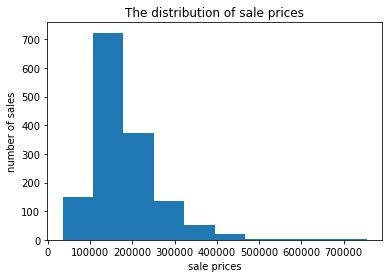

In [6]:
# Feature selection.
house_copy = house_copy[['mssubclass', 'lotarea', 'overallqual', 'overallcond', 'yearbuilt', 'yearremodadd', 
                        'bsmtfinsf1', 'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'firstflrsf', 'secondflrsf', 
                        'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath','halfbath', 
                        'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd', 'fireplaces', 'garagecars', 'garagearea', 
                        'wooddecksf', 'openporchsf', 'enclosedporch', 'threessnporch', 'screenporch','poolarea', 
                        'miscval', 'mosold', 'yrsold', 'mszoning', 'street', 'lotshape', 'landcontour', 
                        'utilities', 'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2', 
                        'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st', 'exterior2nd', 
                        'exterqual', 'extercond', 'foundation', 'heating', 'heatingqc', 'centralair', 
                        'kitchenqual', 'functional', 'paveddrive', 'saletype', 'salecondition', 'saleprice']]
house_copy.info()

# Is the `saleprice` variable normally distributed?
plt.hist(house_copy.saleprice)
plt.title("The distribution of sale prices")
plt.xlabel("sale prices")
plt.ylabel("number of sales")
plt.show()

In [7]:
# The variable is not normally distributed.

# Get correlations of the numeric features.
non_numeric_columns = house_copy.select_dtypes(['object']).columns
numeric_columns = house_copy.select_dtypes(['int64', 'float64']).columns
np.abs(house_copy[numeric_columns].iloc[:, 1:].corr().loc[:, "saleprice"]).sort_values(ascending=False)

saleprice        1.000000
overallqual      0.790982
grlivarea        0.708624
garagecars       0.640409
garagearea       0.623431
totalbsmtsf      0.613581
firstflrsf       0.605852
fullbath         0.560664
totrmsabvgrd     0.533723
yearbuilt        0.522897
yearremodadd     0.507101
fireplaces       0.466929
bsmtfinsf1       0.386420
wooddecksf       0.324413
secondflrsf      0.319334
openporchsf      0.315856
halfbath         0.284108
lotarea          0.263843
bsmtfullbath     0.227122
bsmtunfsf        0.214479
bedroomabvgr     0.168213
kitchenabvgr     0.135907
enclosedporch    0.128578
screenporch      0.111447
poolarea         0.092404
overallcond      0.077856
mosold           0.046432
threessnporch    0.044584
yrsold           0.028923
lowqualfinsf     0.025606
miscval          0.021190
bsmthalfbath     0.016844
bsmtfinsf2       0.011378
Name: saleprice, dtype: float64

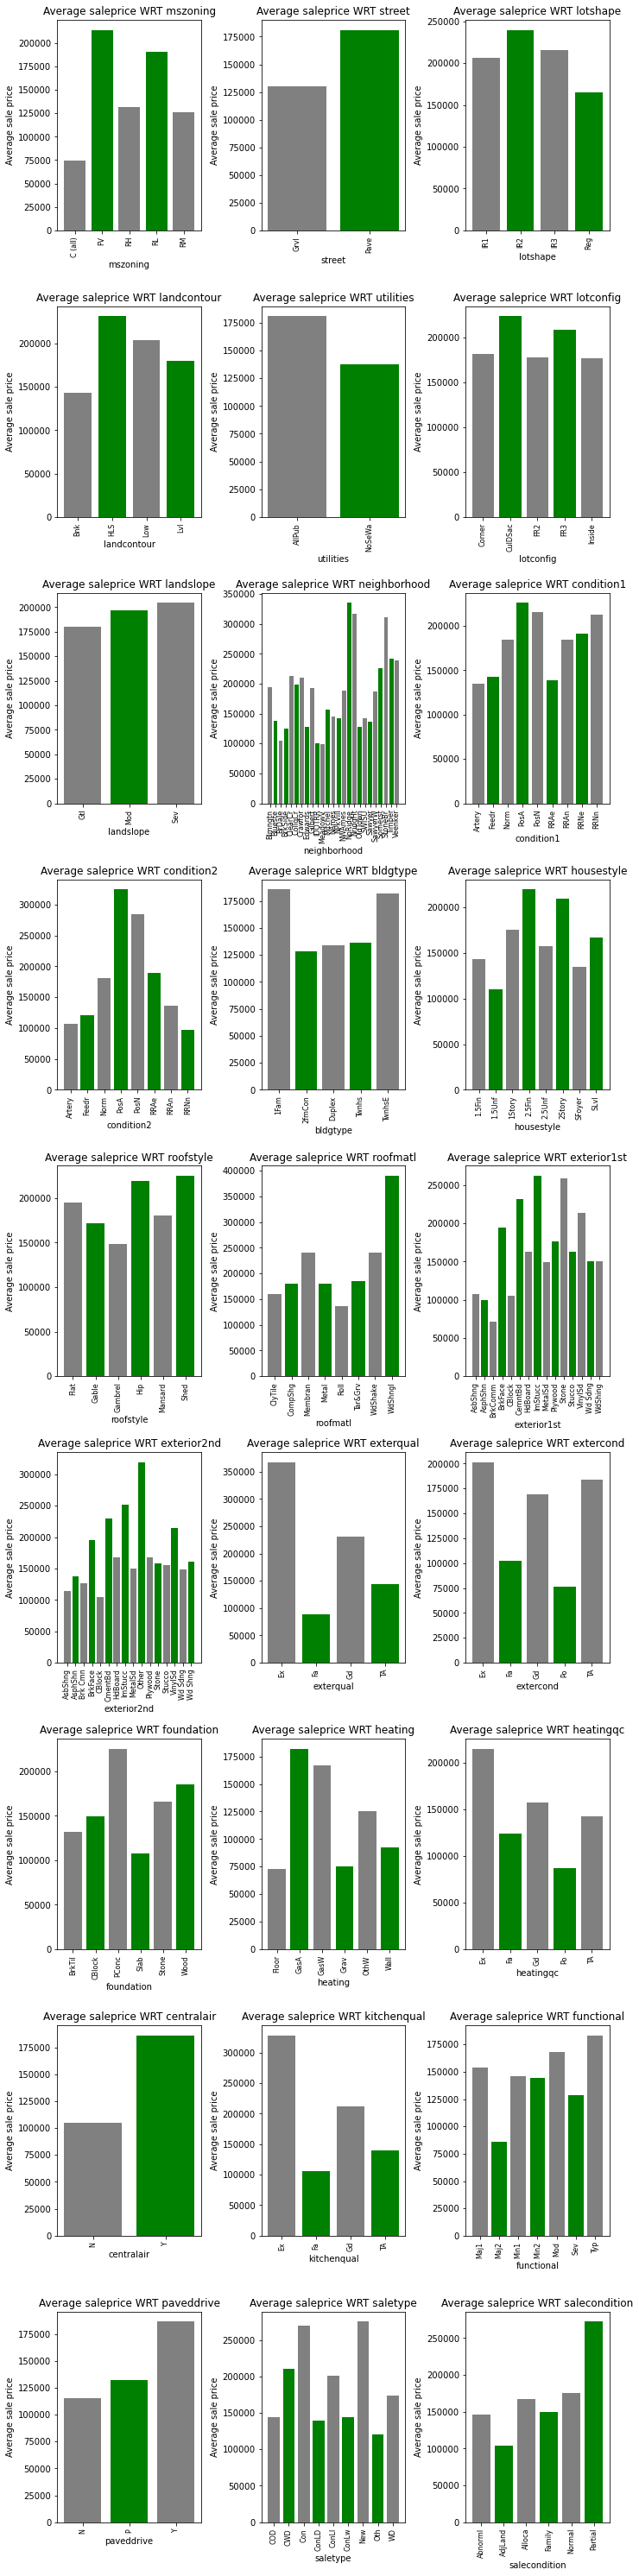

In [8]:
# To understand the univariate relation between our target variable and non-numerical features, 
# we plot each feature against the target variable to show the average sale prices WRT each feature. 

plt.figure(figsize = (10,50))

for index, column in enumerate(non_numeric_columns):
    plt.subplot(11, 3, index+1)
    plt.bar(house_copy.groupby(column)["saleprice"].mean().index, house_copy.groupby(column)["saleprice"].mean(), color=("grey", "green"))
    plt.title("Average saleprice WRT {}".format(column))
    plt.xlabel(column)
    plt.ylabel("Average sale price")
    plt.xticks(rotation='vertical', fontsize='8')
    
plt.tight_layout()
plt.show()

The graphs show that `mszoning` and `street` features are the best non-numeric features to add.

We will add six numerical variables and the two non-numeric variables for our model: `overallqual`, `grlivarea`, `garagecars`, `garagearea`, `totalbsmtsf`, `firstflrsf`, `mszoning`, and `street`.

In [9]:
house_copy_final = house_copy[['saleprice', 'overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalbsmtsf', 'firstflrsf']]

house_copy_final=pd.concat([house_copy_final, pd.get_dummies(house_copy.mszoning, prefix="mszoning", drop_first=True)], axis=1)
house_copy_final=pd.concat([house_copy_final, pd.get_dummies(house_copy.street, prefix="street", drop_first=True)], axis=1)
dummy_columns=list(pd.get_dummies(house_copy.mszoning, prefix="mszoning", drop_first=True).columns)
dummy_columns=dummy_columns+list(pd.get_dummies(house_copy.street, prefix="street", drop_first=True).columns)

print(dummy_columns)
house_copy_final.info()

['mszoning_FV', 'mszoning_RH', 'mszoning_RL', 'mszoning_RM', 'street_Pave']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   saleprice    1460 non-null   int64
 1   overallqual  1460 non-null   int64
 2   grlivarea    1460 non-null   int64
 3   garagecars   1460 non-null   int64
 4   garagearea   1460 non-null   int64
 5   totalbsmtsf  1460 non-null   int64
 6   firstflrsf   1460 non-null   int64
 7   mszoning_FV  1460 non-null   uint8
 8   mszoning_RH  1460 non-null   uint8
 9   mszoning_RL  1460 non-null   uint8
 10  mszoning_RM  1460 non-null   uint8
 11  street_Pave  1460 non-null   uint8
dtypes: int64(7), uint8(5)
memory usage: 87.1 KB


In [10]:
Y = house_copy_final['saleprice']
X = house_copy_final[['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalbsmtsf', 'firstflrsf', 
                     'mszoning_FV', 'mszoning_RH', 'mszoning_RL', 'mszoning_RM', 'street_Pave']]

X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     438.6
Date:                Tue, 07 Dec 2021   Prob (F-statistic):               0.00
Time:                        21:34:37   Log-Likelihood:                -17474.
No. Observations:                1460   AIC:                         3.497e+04
Df Residuals:                    1448   BIC:                         3.504e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1.189e+05   1.81e+04     -6.579      

In [11]:
# Adjust features based on the results.
Y = house_copy_final['saleprice']
X = house_copy_final[['overallqual', 'grlivarea', 'garagecars', 'totalbsmtsf', 'firstflrsf', 'mszoning_RL']]

X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     798.0
Date:                Tue, 07 Dec 2021   Prob (F-statistic):               0.00
Time:                        21:34:37   Log-Likelihood:                -17480.
No. Observations:                1460   AIC:                         3.497e+04
Df Residuals:                    1453   BIC:                         3.501e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1.101e+05   4991.742    -22.054      

In [12]:
# Adjust features based on the results.
Y = house_copy_final['saleprice']
X = house_copy_final[['overallqual', 'grlivarea', 'garagecars', 'totalbsmtsf', 'mszoning_RL']]

X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     956.8
Date:                Tue, 07 Dec 2021   Prob (F-statistic):               0.00
Time:                        21:34:37   Log-Likelihood:                -17481.
No. Observations:                1460   AIC:                         3.497e+04
Df Residuals:                    1454   BIC:                         3.501e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1.083e+05   4804.236    -22.540      

### Now, split your data into train and test sets where 20% of the data resides in the test set.

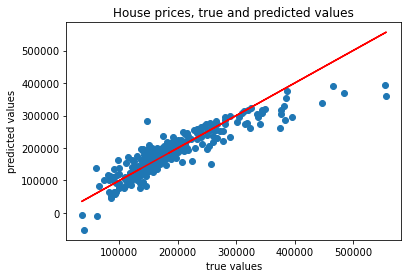

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.754
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     714.0
Date:                Tue, 07 Dec 2021   Prob (F-statistic):               0.00
Time:                        21:34:37   Log-Likelihood:                -14008.
No. Observations:                1168   AIC:                         2.803e+04
Df Residuals:                    1162   BIC:                         2.806e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1.078e+05   5516.854    -19.547      

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 22)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

lrm = LinearRegression()
lrm.fit(X_train, y_train)

y_preds = lrm.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color='red')
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("House prices, true and predicted values")
plt.show()

results = sm.OLS(y_train, X_train).fit()
print(results.summary())

print("Number of training set observation: {} \nNumber of test set observation: {}".format(X_train.shape[0], X_test.shape[0]))

### Build several linear regression models including lasso, ridge, or elastic net, and train them in the training set. Use k-fold cross-validation to select the best hyperparameters if your models include one.

In [14]:
print("-----OLS-----")
print("R-squared of the model in the training set: {}".format(lrm.score(X_train, y_train)))
print("R-squared of the model in the test set: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction: {}".format(np.mean(np.abs((y_test-y_preds)/y_test))*100))

lassoregr = LassoCV()
lassoregr.fit(X_train, y_train)
y_preds_lasso = lassoregr.predict(X_test)

print("-----Lasso-----")
print("R-squared of the model in the training set: {}".format(lassoregr.score(X_train, y_train)))
print("R-squared of the model in the test set: {}".format(lassoregr.score(X_test, y_test)))
print("Mean absolute error of the prediction: {}".format(mean_absolute_error(y_test, y_preds_lasso)))
print("Mean squared error of the prediction: {}".format(mse(y_test, y_preds_lasso)))
print("Root mean squared error of the prediction: {}".format(rmse(y_test, y_preds_lasso)))
print("Mean absolute percentage error of the prediction: {}".format(np.mean(np.abs((y_test-y_preds_lasso)/y_test))*100))

ridgeregr = RidgeCV()
ridgeregr.fit(X_train, y_train)
y_preds_ridge = ridgeregr.predict(X_test)

print("-----Ridge-----")
print("R-squared of the model in the training set: {}".format(ridgeregr.score(X_train, y_train)))
print("R-squared of the model in the test set: {}".format(ridgeregr.score(X_test, y_test)))
print("Mean absolute error of the prediction: {}".format(mean_absolute_error(y_test, y_preds_ridge)))
print("Mean squared error of the prediction: {}".format(mse(y_test, y_preds_ridge)))
print("Root mean squared error of the prediction: {}".format(rmse(y_test, y_preds_ridge)))
print("Mean absolute percentage error of the prediction: {}".format(np.mean(np.abs((y_test-y_preds_ridge)/y_test))*100))

elasticregr = ElasticNetCV()
elasticregr.fit(X_train, y_train)
y_preds_elastic = elasticregr.predict(X_test)

print("-----Elastic Net-----")
print("R-squared of the model on the training set: {}".format(elasticregr.score(X_train, y_train)))
print("R-squared of the model on the test set: {}".format(elasticregr.score(X_test, y_test)))
print("Mean absolute error of the prediction: {}".format(mean_absolute_error(y_test, y_preds_elastic)))
print("Mean squared error of the prediction: {}".format(mse(y_test, y_preds_elastic)))
print("Root mean squared error of the prediction: {}".format(rmse(y_test, y_preds_elastic)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_elastic) / y_test)) *100))


-----OLS-----
R-squared of the model in the training set: 0.7544335307528607
R-squared of the model in the test set: 0.8111536142695607
Mean absolute error of the prediction: 24504.45966634617
Mean squared error of the prediction: 1242927792.1508596
Root mean squared error of the prediction: 35255.18106818996
Mean absolute percentage error of the prediction: 15.364165919309638
-----Lasso-----
R-squared of the model in the training set: 0.602909948887119
R-squared of the model in the test set: 0.7200472346269767
Mean absolute error of the prediction: 29478.787279150743
Mean squared error of the prediction: 1842561461.9297063
Root mean squared error of the prediction: 42925.06798980878
Mean absolute percentage error of the prediction: 17.197189127617072
-----Ridge-----
R-squared of the model in the training set: 0.7544335277950144
R-squared of the model in the test set: 0.8111573295327492
Mean absolute error of the prediction: 24503.913791708124
Mean squared error of the prediction: 1242

### Evaluate your best model on the test set.
Based on the regression results, Ridge seems to be the best regression model. The difference in $R^2$ values were the smallest, and the MAE, MSE, RMSE, and MAPE were the lowest. The next best model was OLS, which was very close to the Ridge model.

# Random Forest

In [16]:
house_copy_final.info()
house_copy_final.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   saleprice    1460 non-null   int64
 1   overallqual  1460 non-null   int64
 2   grlivarea    1460 non-null   int64
 3   garagecars   1460 non-null   int64
 4   garagearea   1460 non-null   int64
 5   totalbsmtsf  1460 non-null   int64
 6   firstflrsf   1460 non-null   int64
 7   mszoning_FV  1460 non-null   uint8
 8   mszoning_RH  1460 non-null   uint8
 9   mszoning_RL  1460 non-null   uint8
 10  mszoning_RM  1460 non-null   uint8
 11  street_Pave  1460 non-null   uint8
dtypes: int64(7), uint8(5)
memory usage: 87.1 KB


,saleprice,overallqual,grlivarea,garagecars,garagearea,totalbsmtsf,firstflrsf,mszoning_FV,mszoning_RH,mszoning_RL,mszoning_RM,street_Pave
0,208500,7,1710,2,548,856,856,0,0,1,0,1
1,181500,6,1262,2,460,1262,1262,0,0,1,0,1
2,223500,7,1786,2,608,920,920,0,0,1,0,1
3,140000,7,1717,3,642,756,961,0,0,1,0,1
4,250000,8,2198,3,836,1145,1145,0,0,1,0,1


In [19]:
rfc = ensemble.RandomForestClassifier()
X = house_copy_final.drop('saleprice', 1)
Y = house_copy_final['saleprice']
X = pd.get_dummies(X)

cross_val_score(rfc, X, Y, cv=20)

array([0.        , 0.        , 0.01369863, 0.        , 0.        ,
       0.        , 0.02739726, 0.01369863, 0.        , 0.        ,
       0.01369863, 0.        , 0.01369863, 0.01369863, 0.01369863,
       0.        , 0.        , 0.01369863, 0.01369863, 0.01369863])